DATA PREPROCESSING

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

transactions = pd.read_csv('transactions.csv')
product_catalog = pd.read_csv('product_catalog.csv')
product_category_map = pd.read_csv('product_category_map.csv')

print("Transactions missing data:\n", transactions.isnull().sum())
print("Product catalog missing data:\n", product_catalog.isnull().sum())
print("Product category map missing data:\n", product_category_map.isnull().sum())


# convert date column to datetime format
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])

# handle missing categories in product catalog
product_catalog['categories'] = product_catalog['categories'].apply(lambda x: eval(x) if isinstance(x, str) else [])

# merge datasets
merged_data = transactions.merge(product_catalog, on='product_id', how='left')
merged_data = merged_data.explode('categories') # flatten allows to seperate the transaction into seperate individual categories
merged_data = merged_data.merge(product_category_map, left_on='categories', right_on='category_id', how='left')

# create new columns(features)
merged_data['purchase_month'] = merged_data['purchase_date'].dt.month
merged_data['purchase_weekday'] = merged_data['purchase_date'].dt.weekday
merged_data['purchase_year'] = merged_data['purchase_date'].dt.year

# keep data only included in valid transaction records and save it
cleaned_data = merged_data.dropna(subset=['customer_id', 'product_id'])
cleaned_data.to_csv('cleaned_data.csv', index=False)


Transactions missing data:
 customer_id      0
product_id       0
purchase_date    0
quantity         0
dtype: int64
Product catalog missing data:
 product_id            0
manufacturer_id       0
attribute_1           0
attribute_2           0
attribute_3           0
attribute_4           0
attribute_5           0
categories         6788
dtype: int64
Product category map missing data:
 category_id           0
parent_category_id    0
dtype: int64


EDA

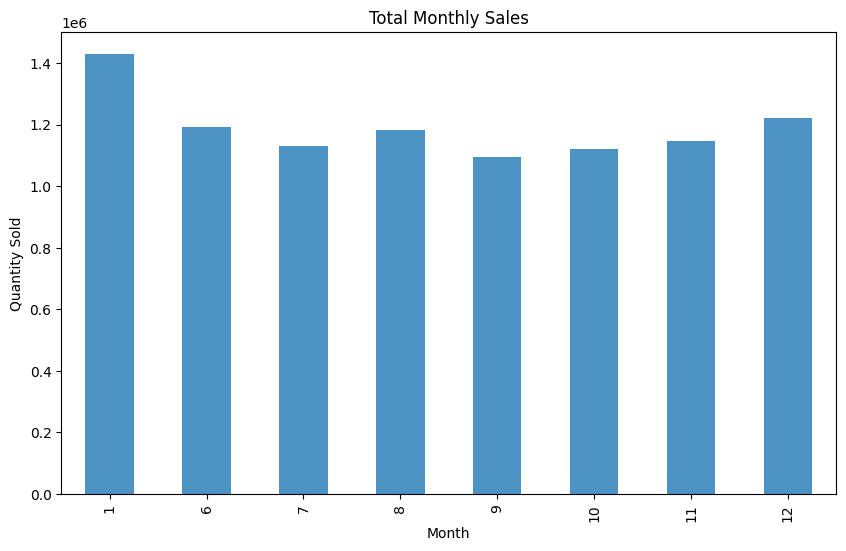

In [7]:
# total sales volume for each month
monthly_sales = cleaned_data.groupby('purchase_month')['quantity'].sum()
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar', alpha=0.8)
plt.title("Total Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.show()


C:\Users\tessj\AppData\Local\Temp\ipykernel_37184\3854600939.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette="viridis")


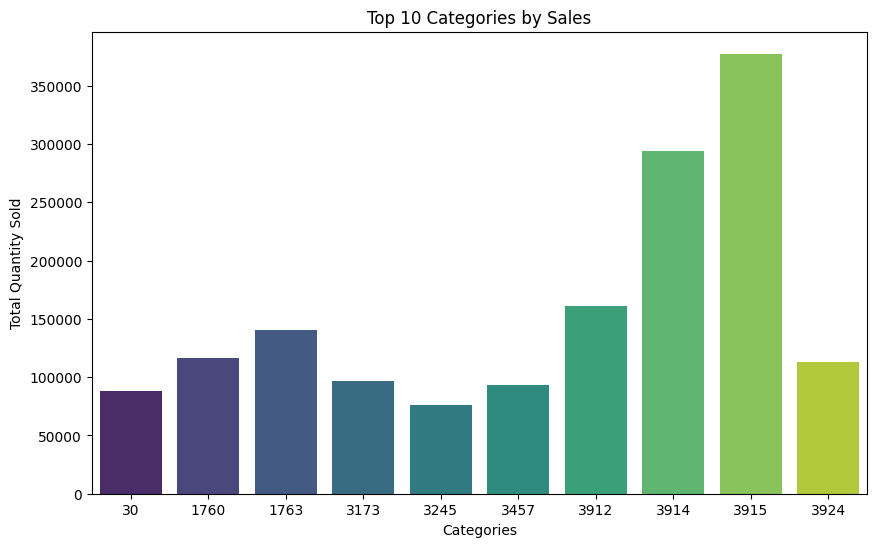

In [8]:
# popular categories
top_categories = cleaned_data.groupby('categories')['quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories.index, y=top_categories.values, palette="viridis")
plt.title("Top 10 Categories by Sales")
plt.xlabel("Categories")
plt.ylabel("Total Quantity Sold")
plt.show()


C:\Users\tessj\AppData\Local\Temp\ipykernel_37184\3502436347.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.index.astype(str), y=top_products.values, palette="coolwarm")


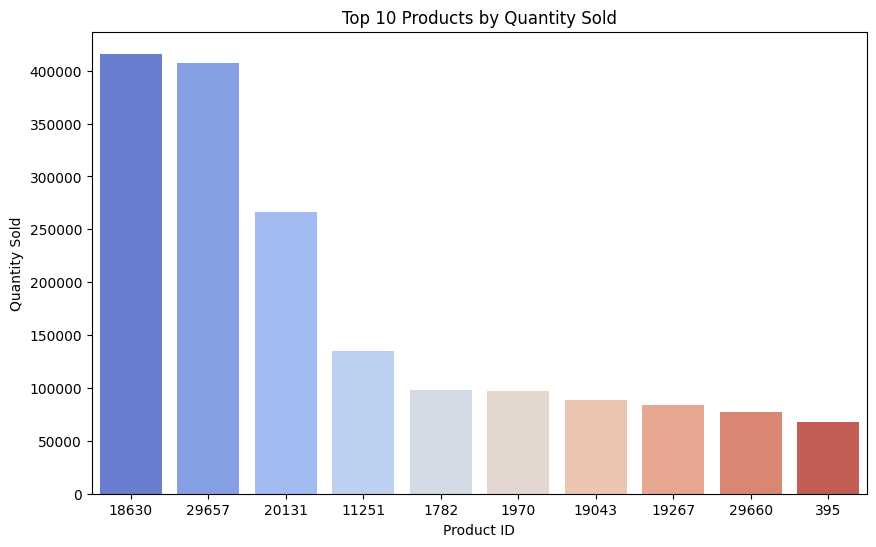

In [9]:
# popular products
top_products = cleaned_data.groupby('product_id')['quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.index.astype(str), y=top_products.values, palette="coolwarm")
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Product ID")
plt.ylabel("Quantity Sold")
plt.show()

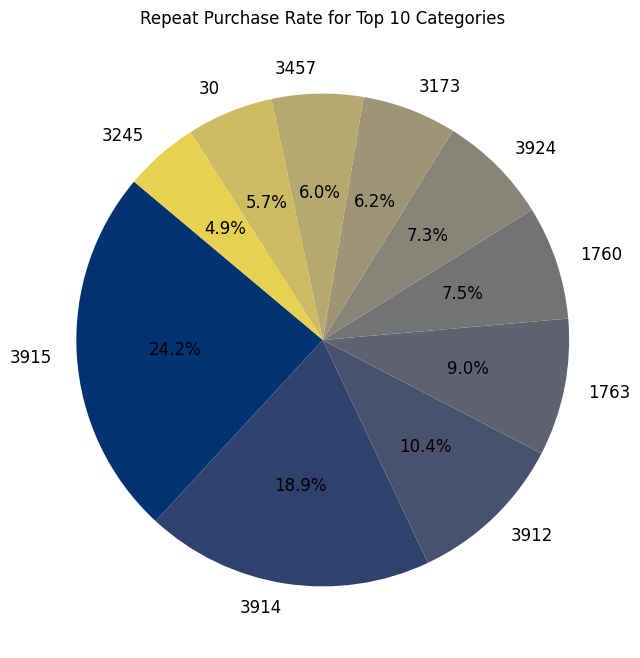

In [12]:

# frequency of purchasing top 10 categories
top_10_categories = (
    cleaned_data.groupby('categories')['quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)
filtered_data = cleaned_data[cleaned_data['categories'].isin(top_10_categories)]
repeat_purchases = (
    filtered_data.groupby(['customer_id', 'categories'])['quantity']
    .sum()
    .reset_index()
)
repeat_rate = (
    repeat_purchases.groupby('categories')['quantity']
    .sum()
    .sort_values(ascending=False)
)
repeat_rate = repeat_rate[repeat_rate.index.isin(top_10_categories)]
plt.figure(figsize=(8, 8))
plt.pie(
    repeat_rate.values,
    labels=repeat_rate.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("cividis", len(repeat_rate)),
    textprops={'fontsize': 12}
)
plt.title("Repeat Purchase Rate for Top 10 Categories")
plt.show()




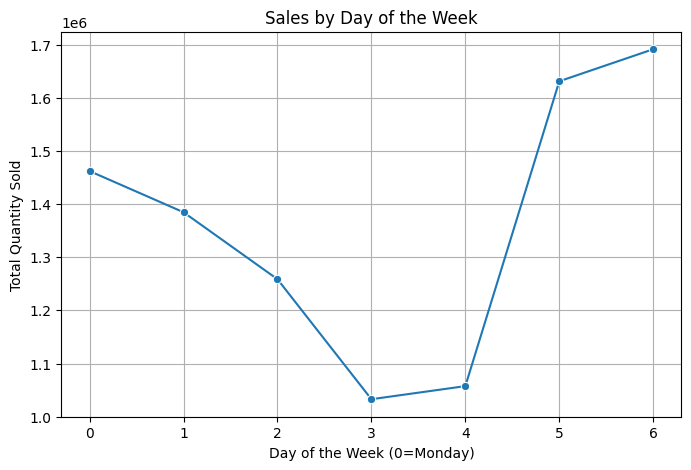

In [10]:

# purchase variation by day of the week
weekday_sales = cleaned_data.groupby('purchase_weekday')['quantity'].sum()
plt.figure(figsize=(8, 5))
sns.lineplot(x=weekday_sales.index, y=weekday_sales.values, marker='o')
plt.title("Sales by Day of the Week")
plt.xlabel("Day of the Week (0=Monday)")
plt.ylabel("Total Quantity Sold")
plt.grid()
plt.show()

REPEAT PURCHASES TRENDS

In [ ]:
# grouping by day to calculate repeat purchases over time
repeat_purchases_daily = (
    cleaned_data.groupby('purchase_date')['product_id']
    .count()
    .reset_index()
)
repeat_purchases_daily.columns = ['date', 'repeat_purchases']

# adding weekdays
repeat_purchases_daily['weekday'] = repeat_purchases_daily['date'].dt.weekday


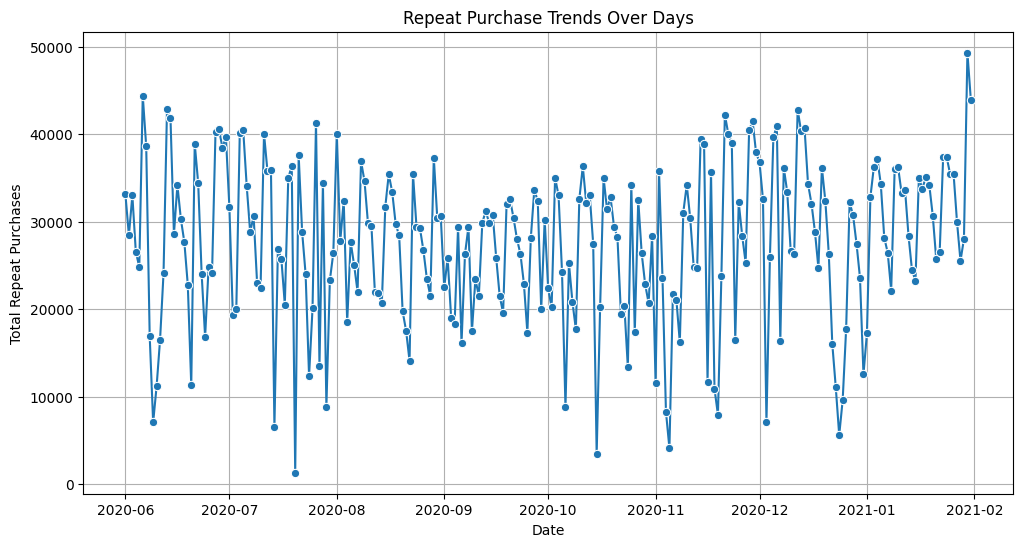

In [4]:
# daily trends
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=repeat_purchases_daily['date'],
    y=repeat_purchases_daily['repeat_purchases'],
    marker='o'
)
plt.title("Repeat Purchase Trends Over Days")
plt.xlabel("Date")
plt.ylabel("Total Repeat Purchases")
plt.grid()
plt.show()


C:\Users\tessj\AppData\Local\Temp\ipykernel_37184\2725780115.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_trends.index, y=weekday_trends.values, palette="viridis")


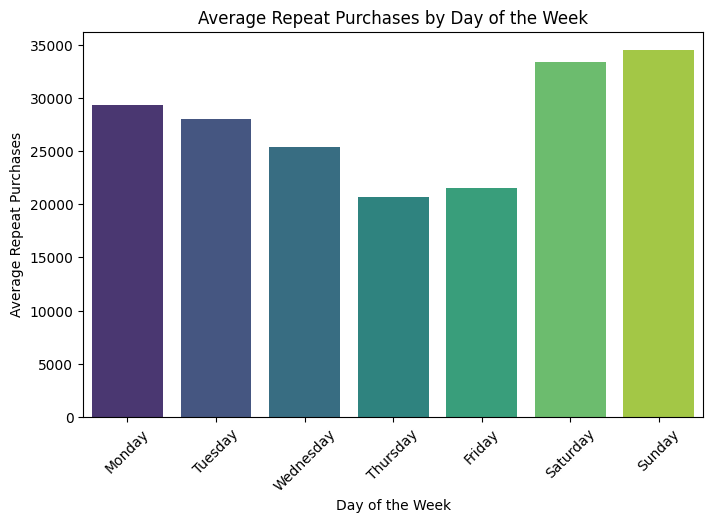

In [5]:
# grouping by weekday to find average purchases per day of the week
weekday_trends = repeat_purchases_daily.groupby('weekday')['repeat_purchases'].mean()

# weekday numbers to names
weekday_trends.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# weekday patterns
plt.figure(figsize=(8, 5))
sns.barplot(x=weekday_trends.index, y=weekday_trends.values, palette="viridis")
plt.title("Average Repeat Purchases by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Repeat Purchases")
plt.xticks(rotation=45)
plt.show()


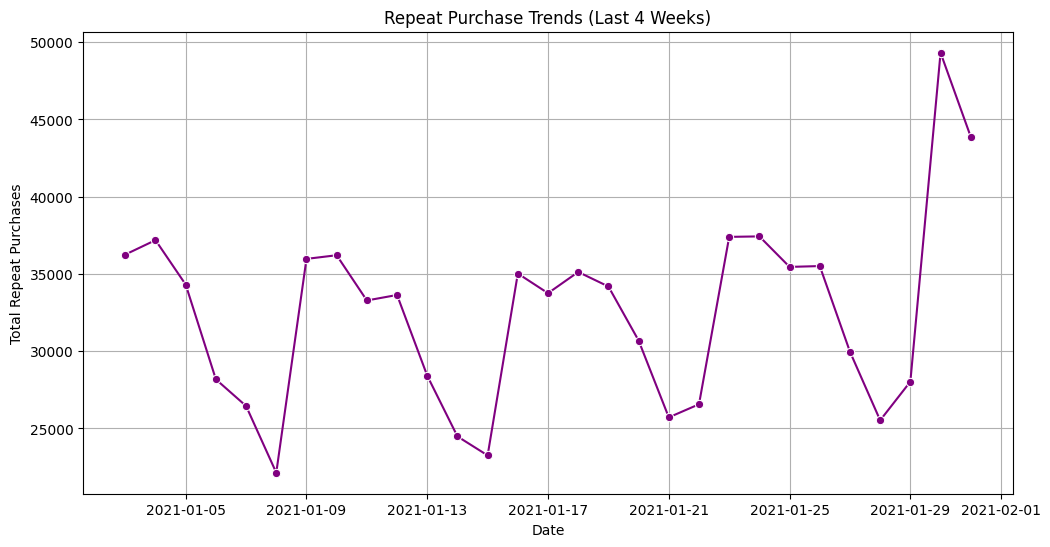

In [6]:
# data for the last 4 weeks of the data set
latest_date = repeat_purchases_daily['date'].max()
four_weeks_ago = latest_date - pd.Timedelta(days=28)
recent_trends = repeat_purchases_daily[repeat_purchases_daily['date'] >= four_weeks_ago]

# trends for the last 4 weeks
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=recent_trends['date'],
    y=recent_trends['repeat_purchases'],
    marker='o',
    color='purple'
)
plt.title("Repeat Purchase Trends (Last 4 Weeks)")
plt.xlabel("Date")
plt.ylabel("Total Repeat Purchases")
plt.grid()
plt.show()
